# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [0]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [0]:
df = df.drop(['diagnosis', "Unnamed: 32"], axis=1)
df = df[df.isnull().any(axis=1)==False]
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [0]:
print(df.shape)

(569, 31)


## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


In [0]:
df_test1 = df.copy()

In [0]:
# Perform K-Means Clustering on the Dataset
from sklearn.preprocessing import StandardScaler

myscaler = StandardScaler()

In [0]:
df_processed1 = myscaler.fit_transform(df_test1)

In [0]:
features = list(df.columns)

In [0]:
df_scaled = pd.DataFrame(df_processed1, columns=features)
df_scaled.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-0.236405,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,-0.236403,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,0.431741,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,0.432121,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,0.432201,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [0]:
from sklearn.decomposition import PCA
mypca = PCA(n_components=10)

In [0]:
pca_features = mypca.fit_transform(df_scaled)

In [0]:
mypca.explained_variance_ratio_

array([0.42864701, 0.18376792, 0.09146436, 0.06391475, 0.05318759,
       0.03982815, 0.0315572 , 0.02166945, 0.01486427, 0.01300429])

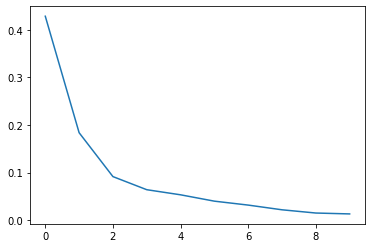

In [0]:
import numpy as np

vals = mypca.explained_variance_ratio_
num_com = len(vals)
ind = np.arange(num_com)

plt.plot(ind, vals)

# looks like the elbow is around 2 kmeans

In [0]:
# reset 
df_test2 = df.copy()

In [0]:
scaler2 = StandardScaler()
scaled_df2 = scaler2.fit_transform(df_test2)

In [0]:
df_scaled2 = pd.DataFrame(scaled_df2, columns=features)

In [0]:
df_scaled2.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-0.236405,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,-0.236403,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,0.431741,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,0.432121,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,0.432201,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [0]:
my_pca2 = PCA(n_components=2)
pca_features = my_pca2.fit_transform(df_scaled2)

In [0]:
sum(my_pca2.explained_variance_ratio_)

0.6124149284660223

In [0]:
df_pca2 = pd.DataFrame(pca_features, columns=['comp1', 'comp2'])

In [0]:
df_pca2.head()

,comp1,comp2
0,9.183200,1.971271
1,2.383298,-3.753459
2,5.742472,-1.080350
3,7.124384,10.272225
4,3.945694,-1.959689


In [0]:
from sklearn.cluster import KMeans
my_kmeans = KMeans(n_clusters=2)

my_kmeans.fit(df_pca2.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
df_pca2['cluster'] = my_kmeans.labels_
df_pca2.head()
print(df_pca2.shape)

(569, 3)


In [0]:
df_pca2['cluster'].value_counts()

0    378
1    191
Name: cluster, dtype: int64

In [0]:
df_test2['diagnosis'] = df_pca2['cluster']

In [0]:
df_test2.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [0]:
df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0})
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [0]:
print('kmeans test')
print(df_test2['diagnosis'].value_counts())
print()
print('dataset')
print(df['diagnosis'].value_counts())

kmeans test
0    378
1    191
Name: diagnosis, dtype: int64

dataset
0    357
1    212
Name: diagnosis, dtype: int64


In [0]:
# using a confusion matrix to compare accuracy
from sklearn import metrics

In [0]:
m = metrics.confusion_matrix(df['diagnosis'], df_test2['diagnosis'])

In [0]:
cm = pd.DataFrame(m, columns=['pred_0', 'pred_1'])
cm

,pred_0,pred_1
0,341,16
1,37,175


In [0]:
# Accuracy:
TP = cm['pred_1'].values[1]
TN = cm['pred_0'].values[0]
ALL = cm.values.sum()

print(f'Overall the kmeans with 2 clusters had a {((TP+TN)/ALL)*100}% accuracy')

Overall the kmeans with 2 clusters had a 90.68541300527241% accuracy


# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [94]:
##### Your Code Here #####
num_components=0
explained=0.0
for p in mypca.explained_variance_ratio_:
  if explained<.9:
    explained+=p
    num_components+=1
  else:
    break

print(f'You would need {num_components} components in pca to retain at least 90% explained variation')
explained

print("Although greater than 90% total accuracy is possible through kmeans with 2 components")

You would need 8 components in pca to retain at least 90% variation
Although greater than 90% total accuracy is possible through kmeans with 2 components


In [0]:
# run with pca(n_components=8)
df_test3 = df.copy()
df_test3 = df_test3.drop(['diagnosis', "Unnamed: 32"], axis=1)
df_test3 = df_test3[df_test3.isnull().any(axis=1)==False]
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_test3)

In [130]:
df_test3.shape

(569, 31)

In [0]:
df_scaled3 = pd.DataFrame(scaled_df, columns=features)

In [0]:
my_pca3 = PCA(n_components=8)

In [0]:
pca_features3 = my_pca3.fit_transform(df_scaled3)

In [134]:
sum(my_pca3.explained_variance_ratio_)

0.9140364266906503

In [0]:
df_pca3 = pd.DataFrame(pca_features3, columns=['comp'+str(i) for i in range(1,9)])

In [135]:
my_kmeans2 = KMeans(n_clusters=2)

my_kmeans2.fit(df_pca3.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [136]:
df_pca3['cluster'] = my_kmeans2.labels_
df_pca3.head()

,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,cluster
0,9.183200,1.971271,-1.171625,3.639333,-1.193103,-1.372275,0.371825,2.180472,1
1,2.383298,-3.753459,-0.580229,1.127437,0.624854,-0.126620,-0.288258,0.044982,1
2,5.742472,-1.080350,-0.533088,0.903470,-0.180603,-0.401853,0.463177,-0.715217,1
3,7.124384,10.272225,-3.150161,0.121512,-2.968055,-2.561668,1.950178,1.287993,1
4,3.945694,-1.959689,1.401177,2.937555,0.540854,1.233298,-0.205426,-0.959327,1


In [0]:
df_test3['diagnosis'] = df_pca3['cluster']

In [138]:
df_test3['diagnosis'].value_counts()

0    380
1    189
Name: diagnosis, dtype: int64

In [126]:
df_test2['diagnosis'].value_counts()

0    378
1    191
Name: diagnosis, dtype: int64

In [127]:
df['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [0]:
# n_components = 8 for pca resulted in very slightly worse 

In [119]:
df_pca2.head()

,comp1,comp2,cluster
0,9.183200,1.971271,1
1,2.383298,-3.753459,1
2,5.742472,-1.080350,1
3,7.124384,10.272225,1
4,3.945694,-1.959689,1


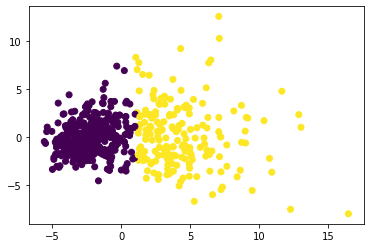

In [120]:
plt.scatter(df_pca2['comp1'], df_pca2['comp2'], c=df_pca2['cluster'])

In [140]:
metrics.silhouette_score(df_pca2, my_kmeans.labels_, metric='euclidean')

0.5147721672110742

In [141]:
metrics.silhouette_score(df_pca3, my_kmeans.labels_, metric='euclidean')

0.3685529273135041

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project